In [0]:
!git clone https://bitbucket.org/jadslim/german-traffic-signs
  

fatal: destination path 'german-traffic-signs' already exists and is not an empty directory.


In [0]:
!ls german-traffic-signs


signnames.csv  test.p  train.p	valid.p


In [0]:
import numpy as np
import matplotlib.pyplot as plt
import keras
from keras.models import Sequential
from keras.optimizers import Adam
from keras.layers import Dense
from keras.layers import Flatten, Dropout
from keras.utils.np_utils import to_categorical
from keras.layers.convolutional import Conv2D, MaxPooling2D
import random
import pickle
import pandas as pd
import cv2
 

Using TensorFlow backend.


In [0]:
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import LearningRateScheduler, ModelCheckpoint


In [0]:
np.random.seed(0)

In [0]:
with open('german-traffic-signs/train.p', 'rb') as f:
    train_data = pickle.load(f)
with open('german-traffic-signs/valid.p', 'rb') as f:
    val_data = pickle.load(f)
with open('german-traffic-signs/test.p', 'rb') as f:
  test_data = pickle.load(f)

print(type(train_data))
X_train, y_train = train_data['features'], train_data['labels']
X_val, y_val = val_data['features'], val_data['labels']
X_test, y_test = test_data['features'], test_data['labels']




<class 'dict'>


In [0]:
print(X_train.shape)
print(X_test.shape)
print(X_val.shape)

(34799, 32, 32, 3)
(12630, 32, 32, 3)
(4410, 32, 32, 3)


In [0]:
assert(X_train.shape[0] == y_train.shape[0]), "The number of images is not equal to the number of labels."
assert(X_train.shape[1:] == (32,32,3)), "The dimensions of the images are not 32 x 32 x 3."
assert(X_val.shape[0] == y_val.shape[0]), "The number of images is not equal to the number of labels."
assert(X_val.shape[1:] == (32,32,3)), "The dimensions of the images are not 32 x 32 x 3."
assert(X_test.shape[0] == y_test.shape[0]), "The number of images is not equal to the number of labels."
assert(X_test.shape[1:] == (32,32,3)), "The dimensions of the images are not 32 x 32 x 3."

In [0]:
data = pd.read_csv('german-traffic-signs/signnames.csv')
print(data)

    ClassId                                           SignName
0         0                               Speed limit (20km/h)
1         1                               Speed limit (30km/h)
2         2                               Speed limit (50km/h)
3         3                               Speed limit (60km/h)
4         4                               Speed limit (70km/h)
5         5                               Speed limit (80km/h)
6         6                        End of speed limit (80km/h)
7         7                              Speed limit (100km/h)
8         8                              Speed limit (120km/h)
9         9                                         No passing
10       10       No passing for vechiles over 3.5 metric tons
11       11              Right-of-way at the next intersection
12       12                                      Priority road
13       13                                              Yield
14       14                                            

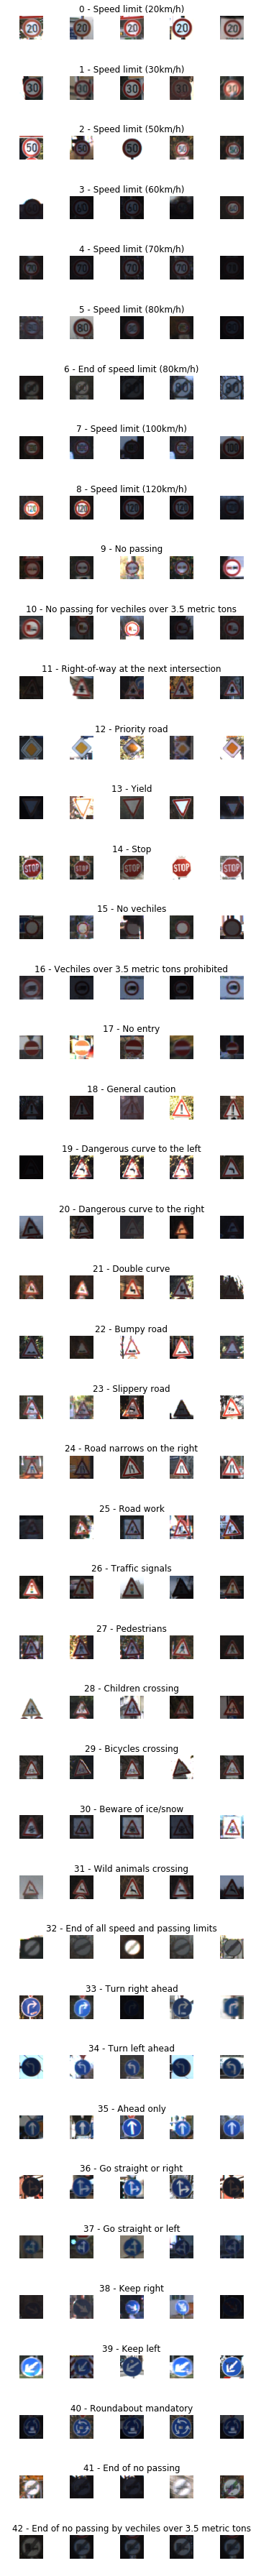

In [0]:
  num_of_samples=[]
 
  cols = 5
  num_classes = 43
 
  fig, axs = plt.subplots(nrows=num_classes, ncols=cols, figsize=(5,50))
  fig.tight_layout()
 
  for i in range(cols):
      for j, row in data.iterrows():
        x_selected = X_train[y_train == j]
        axs[j][i].imshow(x_selected[random.randint(0,(len(x_selected) - 1)), :, :], cmap=plt.get_cmap('gray'))
        axs[j][i].axis("off")
        if i == 2:
          axs[j][i].set_title(str(j) + " - " + row["SignName"])
          num_of_samples.append(len(x_selected))

[180, 1980, 2010, 1260, 1770, 1650, 360, 1290, 1260, 1320, 1800, 1170, 1890, 1920, 690, 540, 360, 990, 1080, 180, 300, 270, 330, 450, 240, 1350, 540, 210, 480, 240, 390, 690, 210, 599, 360, 1080, 330, 180, 1860, 270, 300, 210, 210]


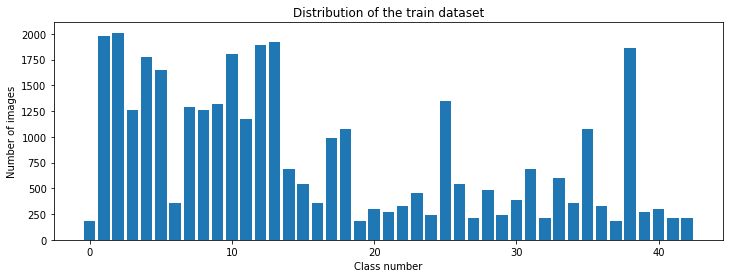

In [0]:
print(num_of_samples)
plt.figure(figsize=(12, 4))
plt.bar(range(0, num_classes), num_of_samples)
plt.title("Distribution of the train dataset")
plt.xlabel("Class number")
plt.ylabel("Number of images")
plt.show()

(32, 32, 3)
36


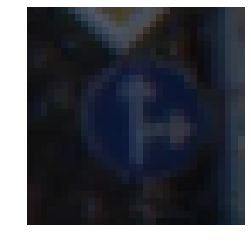

In [0]:

plt.imshow(X_train[1000])
plt.axis("off")
print(X_train[1000].shape)
print(y_train[1000])

(32, 32)


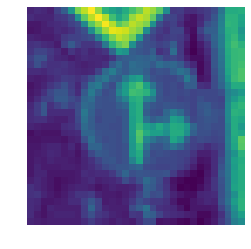

In [0]:
def grayscale(img):
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    return img

img = grayscale(X_train[1000])
plt.imshow(img)
plt.axis("off")
print(img.shape)


(32, 32)


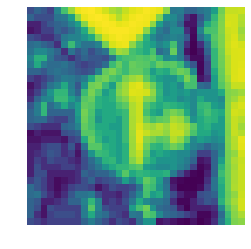

In [0]:
def equalize(img):
    img = cv2.equalizeHist(img)
    return img
img = equalize(img)
plt.imshow(img)
plt.axis("off")
print(img.shape)
  

In [0]:
def preprocess(img):
    img = grayscale(img)
    img = equalize(img)
    img = img/255
    return img

X_train = np.array(list(map(preprocess, X_train)))
X_test = np.array(list(map(preprocess, X_test)))
X_val = np.array(list(map(preprocess, X_val)))

(34799, 32, 32)


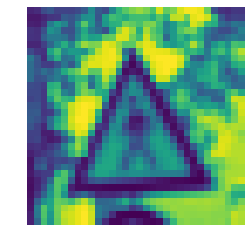

In [0]:
plt.imshow(X_train[random.randint(0, len(X_train) - 1)])
plt.axis('off')
print(X_train.shape)

In [0]:
X_train = X_train.reshape(34799, 32, 32, 1)
X_test = X_test.reshape(12630, 32, 32, 1)
X_val = X_val.reshape(4410, 32, 32, 1)


In [0]:
from keras.preprocessing.image import ImageDataGenerator
datagen = ImageDataGenerator(width_shift_range=0.1,
                            height_shift_range=0.1,
                            zoom_range=0.2,
                            shear_range=0.15,
                            rotation_range=2.0)
 
datagen.fit(X_train)

(15, 32, 32, 1)


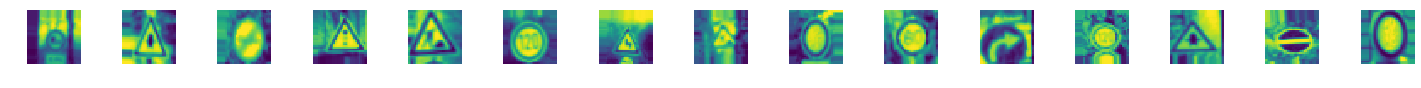

In [0]:
batches = datagen.flow(X_train, y_train, batch_size = 15)
X_batch, y_batch = next(batches)
 
fig, axs = plt.subplots(1, 15, figsize=(20, 5))
fig.tight_layout()
 
for i in range(15):
    axs[i].imshow(X_batch[i].reshape(32, 32))
    axs[i].axis("off")
print(X_batch.shape)

In [0]:
y_train = to_categorical(y_train, 43)
y_test = to_categorical(y_test, 43)
y_val = to_categorical(y_val, 43)

In [0]:

# create model
 
def modified_model():
  model = Sequential()
  model.add(Conv2D(65, (5, 5), input_shape=(32, 32, 1), activation='relu'))
  model.add(Conv2D(65, (5, 5), activation='relu'))
  model.add(MaxPooling2D(pool_size=(2, 2)))
  
  model.add(Conv2D(25, (3, 3), activation='relu'))
  model.add(Conv2D(25, (3, 3), activation='relu'))
  model.add(MaxPooling2D(pool_size=(2, 2)))
  
  model.add(Flatten())
  model.add(Dense(400, activation='relu'))
  model.add(Dropout(0.4))
  model.add(Dense(43, activation='softmax'))
  
  model.compile(Adam(lr = 0.0001), loss='categorical_crossentropy', metrics=['accuracy'])
  return model


In [0]:
model = modified_model()
print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_9 (Conv2D)            (None, 28, 28, 65)        1690      
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 24, 24, 65)        105690    
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 12, 12, 65)        0         
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 10, 10, 25)        14650     
_________________________________________________________________
conv2d_12 (Conv2D)           (None, 8, 8, 25)          5650      
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 4, 4, 25)          0         
_________________________________________________________________
flatten_3 (Flatten)          (None, 400)               0         
__________

In [0]:
history = model.fit_generator(datagen.flow(X_train, y_train, batch_size = 50), steps_per_epoch = 2000, epochs = 10, validation_data = (X_val, y_val), shuffle =1)

Epoch 1/10
2000/2000 [==============================] - 34s 17ms/step - loss: 2.0042 - acc: 0.4390 - val_loss: 0.6082 - val_acc: 0.8295
Epoch 2/10
2000/2000 [==============================] - 34s 17ms/step - loss: 0.9224 - acc: 0.7208 - val_loss: 0.3041 - val_acc: 0.9043
Epoch 3/10
2000/2000 [==============================] - 33s 16ms/step - loss: 0.6146 - acc: 0.8118 - val_loss: 0.2023 - val_acc: 0.9410
Epoch 4/10
2000/2000 [==============================] - 35s 17ms/step - loss: 0.4524 - acc: 0.8616 - val_loss: 0.1507 - val_acc: 0.9542
Epoch 5/10
2000/2000 [==============================] - 32s 16ms/step - loss: 0.3588 - acc: 0.8901 - val_loss: 0.1043 - val_acc: 0.9696
Epoch 6/10
2000/2000 [==============================] - 34s 17ms/step - loss: 0.2918 - acc: 0.9091 - val_loss: 0.1022 - val_acc: 0.9707
Epoch 7/10
1748/2000 [=========================>....] - ETA: 4s - loss: 0.2433 - acc: 0.9239

Text(0.5, 0, 'epoch')

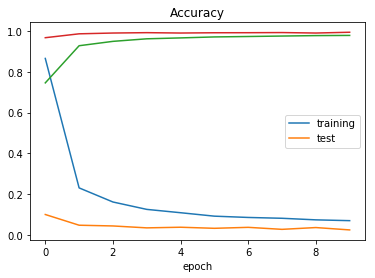

In [0]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Loss')
plt.xlabel('epoch')
 
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.legend(['training','test'])
plt.title('Accuracy')
plt.xlabel('epoch')
 



In [0]:
#import requests
#from PIL import Image
#url = 'https://www.safetysign.com/images/source/large-images/W3625.757cc34e345e3022b117ba47b0dded8f.jpg'
#r = requests.get(url, stream=True)
#img = Image.open(r.raw)
#plt.imshow(img, cmap=plt.get_cmap('gray'))
 
 


In [0]:
# TODO: Evaluate model on test data
score = model.evaluate(X_test, y_test, verbose = 0)
print('Test Score:', score[0])
print('Test Accuracy:', score[1])

Test Score: 0.1119070783994407
Test Accuracy: 0.9768804434076341


(32, 32)
predicted sign: [20]


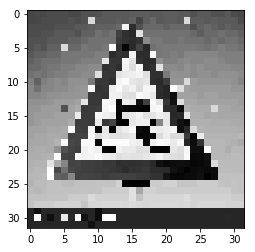

In [0]:
#predict internet number
import requests
from PIL import Image
url = 'https://c8.alamy.com/comp/J2MRAJ/german-road-sign-bicycles-crossing-J2MRAJ.jpg'
r = requests.get(url, stream=True)
img = Image.open(r.raw)
plt.imshow(img, cmap=plt.get_cmap('gray'))
 
img = np.asarray(img)
img = cv2.resize(img, (32, 32))
img = preprocess(img)
plt.imshow(img, cmap = plt.get_cmap('gray'))
print(img.shape)
img = img.reshape(1, 32, 32, 1)
 
print("predicted sign: "+ str(model.predict_classes(img)))